In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import trange
import matplotlib as mpl

mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['xtick.labelsize'] = 'medium'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'medium'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = True
mpl.rcParams['font.size'] = 30
mpl.rcParams["figure.figsize"] = (15,10)

(3401, 3)


(5500.0, 6500.0)

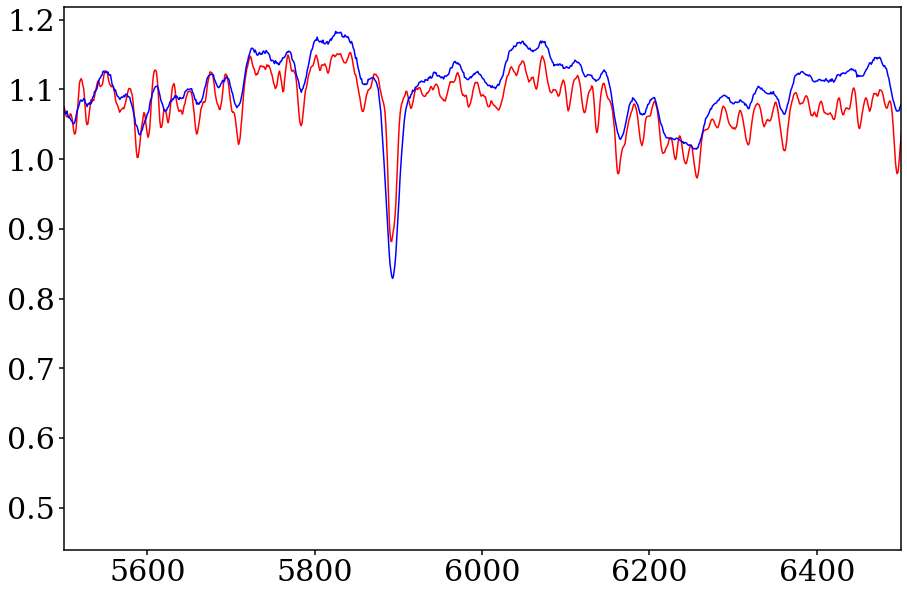

In [2]:
file='./obs/stack_100.00_110.00_skyup.dat' #less massive, younger
file2='./obs/stack_280.00_320.00_skyup.dat' #more massive, older

data=np.loadtxt(file)
data2=np.loadtxt(file2)

print(np.shape(data))
wave=data[:,0]
flux=data[:,1]

wave2=data2[:,0]
flux2=data2[:,1]
plt.plot(wave,flux/np.mean(flux),'r')
plt.plot(wave2,flux2/np.mean(flux2),'b')
plt.xlim(5500,6500)

In [3]:
import os

files= sorted(os.listdir('obs'))
waves=[]
fluxes=[]
sigma_gal=[]
for f in files:
    data=np.loadtxt('./obs/'+f)
    waves.append(data[:,0])
    fluxes.append(data[:,1])
    arr=np.array([float(f[6:12]),float(f[13:19])])
    sigma_gal.append(np.mean(arr))

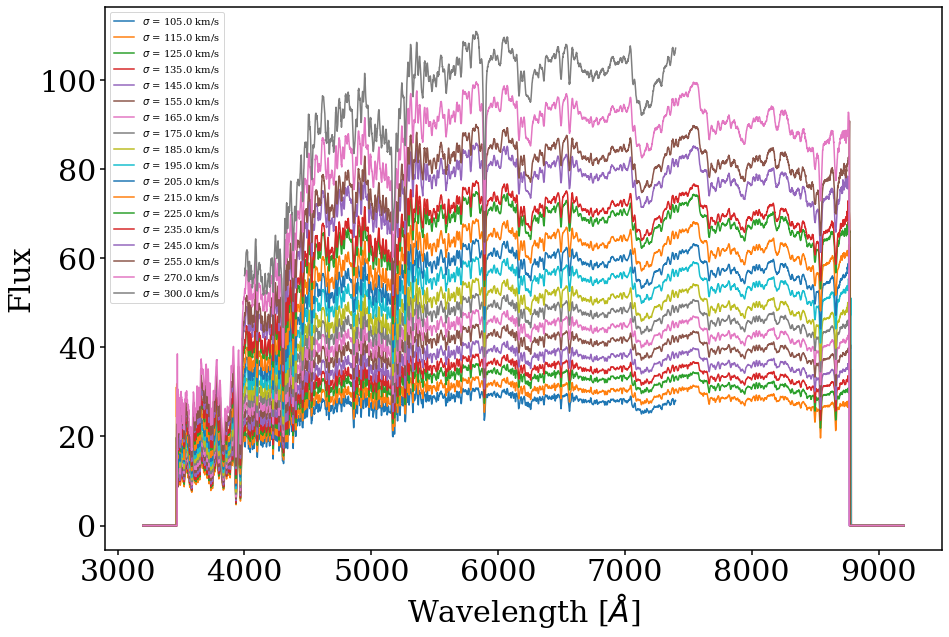

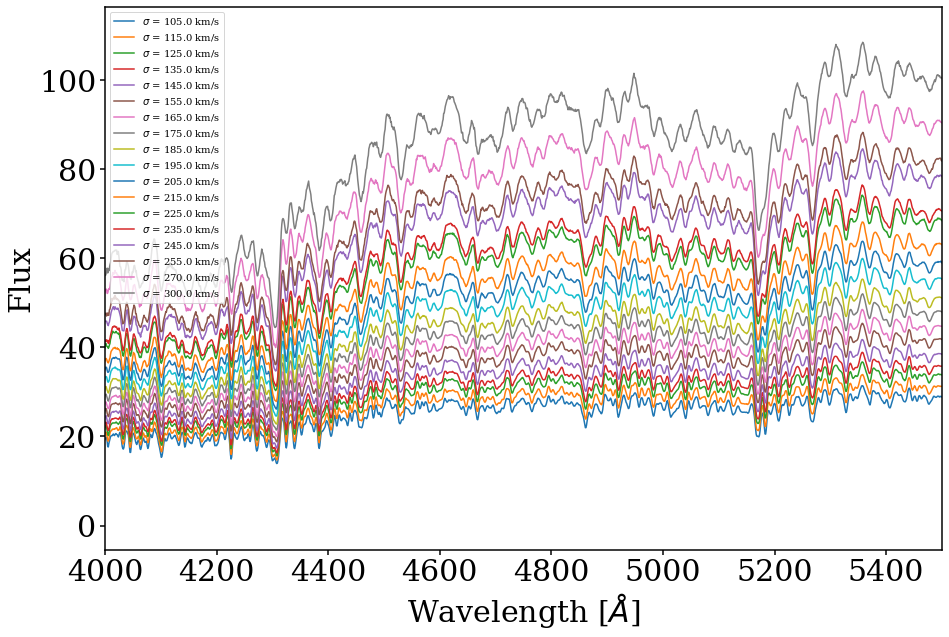

In [4]:
n=len(fluxes)

for i in range(n):
    plt.plot(waves[i],fluxes[i],label='$\\sigma$ = '+str(sigma_gal[i])+' km/s')
plt.ylabel('Flux')
plt.xlabel('Wavelength [$\\AA$]')
plt.legend(fontsize=10)
plt.show()


"""for i in range(n):
    print(np.min(waves[i]),np.max(waves[i]))"""

#largest wavelength range from 4000 to 7400 but we will limit ourselves to the range from 4000 to 5500"

for i in range(n):
    plt.plot(waves[i],fluxes[i],label='$\\sigma$ = '+str(sigma_gal[i])+' km/s')
plt.ylabel('Flux')
plt.xlabel('Wavelength [$\\AA$]')
plt.xlim(4000,5500)
plt.legend(fontsize=10)
plt.show()


In [5]:
fluxes_short=[]
waves_short=[]

for i in range(n):
    ind=np.where((waves[i]>3999)&(waves[i]<7401))[0]
    fluxes_short.append(fluxes[i][ind])
    waves_short.append(waves[i][ind])

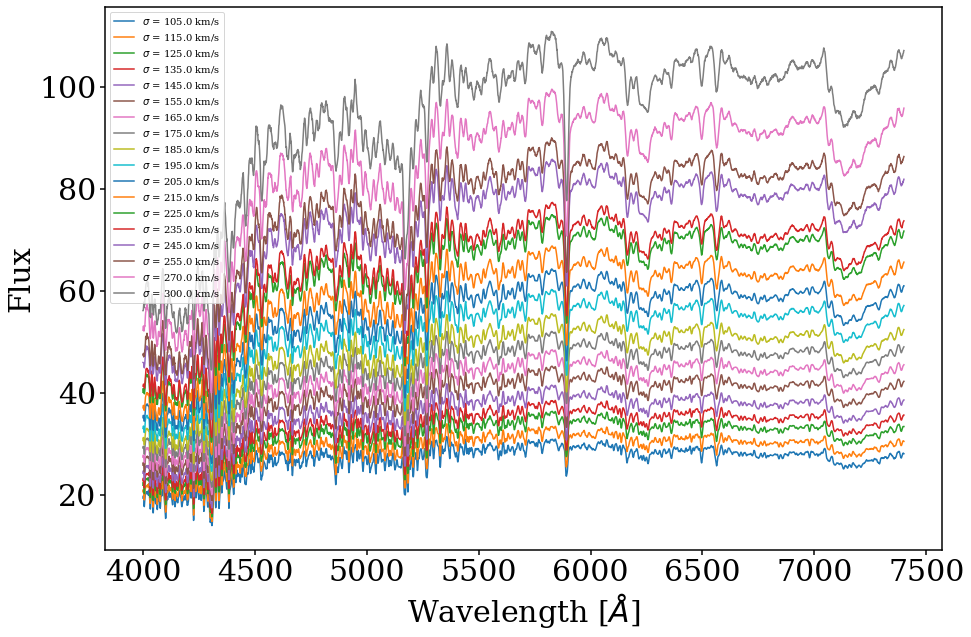

In [6]:
for i in range(n):
    plt.plot(waves_short[i],fluxes_short[i],label='$\\sigma$ = '+str(sigma_gal[i])+' km/s')
plt.ylabel('Flux')
plt.xlabel('Wavelength [$\\AA$]')

plt.legend(fontsize=10)
plt.show()

In [7]:
def gaussian_filter1d(spec, sig):
    """
    Convolve a spectrum by a Gaussian with different sigma for every pixel.
    If all sigma are the same this routine produces the same output as
    scipy.ndimage.gaussian_filter1d, except for the border treatment.
    Here the first/last p pixels are filled with zeros.
    When creating  template library for SDSS data, this implementation
    is 60x faster than a naive for loop over pixels.
    :param spec: vector with the spectrum to convolve
    :param sig: vector of sigma values (in pixels) for every pixel
    :return: spec convolved with a Gaussian with dispersion sig
    """
    sig = sig.clip(0.01)  # forces zero sigmas to have 0.01 pixels
    p = int(np.ceil(np.max(3*sig)))
    m = 2*p + 1  # kernel size
    x2 = np.linspace(-p, p, m)**2
    n = spec.size
    a = np.zeros((m, n))
    for j in range(m):   # Loop over the small size of the kernel
        a[j, p:-p] = spec[j:n-m+j+1]
    gau = np.exp(-x2[:, None]/(2*sig**2))
    gau /= np.sum(gau, 0)[None, :]  # Normalize kernel
    conv_spectrum = np.sum(a*gau, 0)
    return conv_spectrum

$$ \sigma_{gal}^2=\sigma_{v}^2+\sigma_{ins}^2$$

We are going to convert all of them to $v=300$ km/s, so:

$$ \sigma_{diff}^2 = \sigma_{300}^2+\sigma_{ins}^2 - (\sigma_{gal}^2+\sigma_{ins}^2) = \sigma_{300}^2 - \sigma_{gal}^2   $$

And to move from velocity dispersion to kernel width, we will need:

$$
\mathrm{FWHM}=2 \sqrt{2 \ln 2} \sigma \approx 2.35482 \sigma
$$

In [9]:
cvel=300000 #km/s

"""for i in range(n):
    print(waves_short[i],waves_short[i][1]-waves_short[i][0]) #psize=1 A
"""
psize=1
fluxes_conv=[]
max_sigma=np.sqrt(300**2 - np.array(sigma_gal)**2) #velocity dispersion

for i in trange(n):
    FWHM_gal = 2.*np.sqrt(2.*np.log(2.)) * max_sigma[i] / cvel * waves_short[i]
    FWHM_dif = np.sqrt(FWHM_gal**2)
    sigma = FWHM_dif/(psize*2.*np.sqrt(2.*np.log(2.))) # Sigma difference in pixels, for the kernel
    flux_conv = gaussian_filter1d(fluxes_short[i], sigma) 
    fluxes_conv.append(flux_conv)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 270.76it/s]


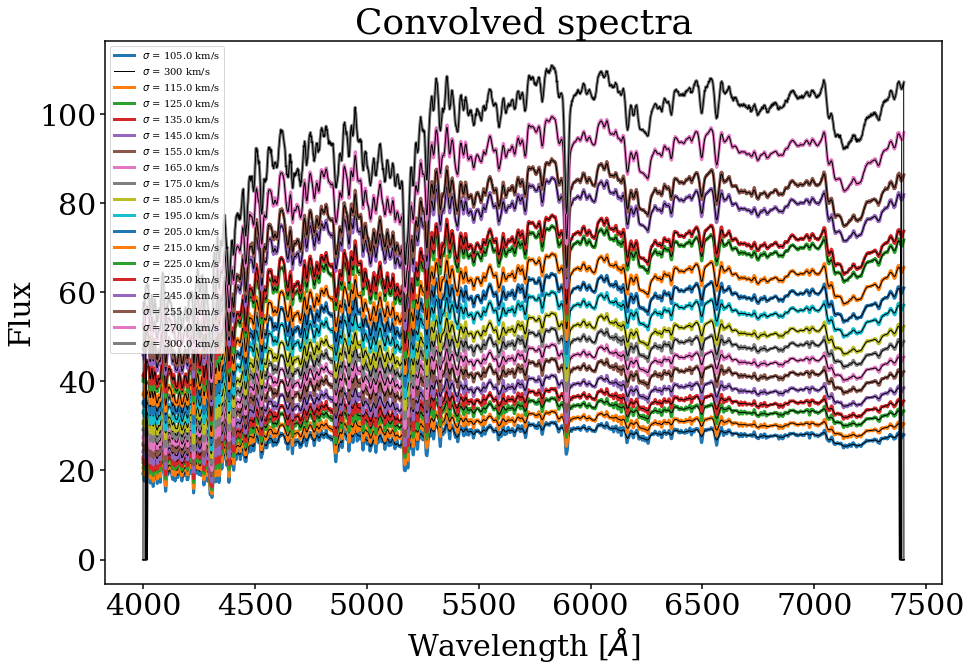

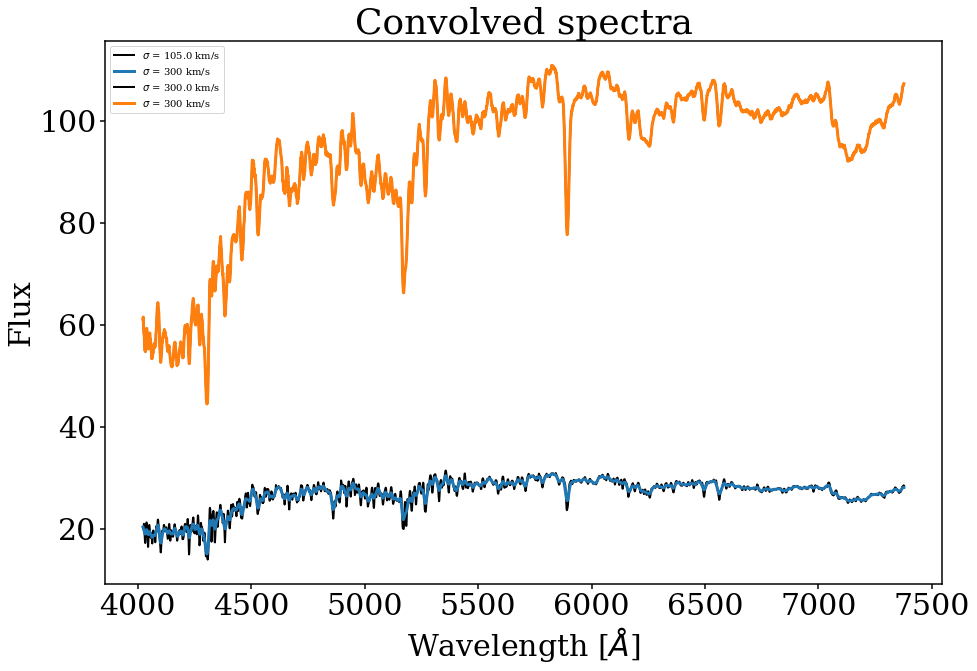

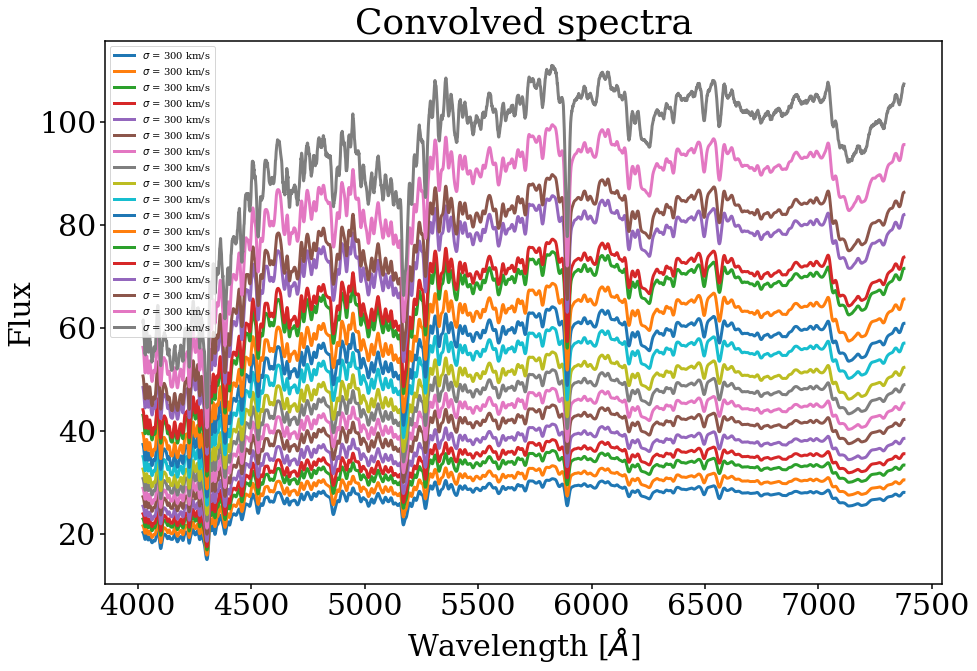

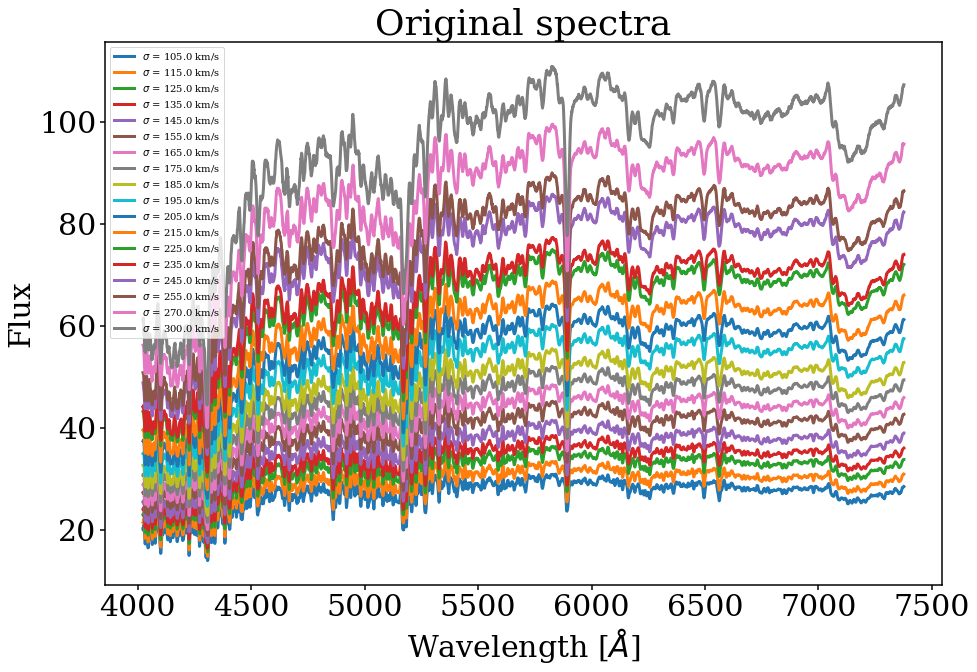

In [12]:
for i in range(n): 
    plt.plot(waves_short[i],fluxes_short[i],label='$\\sigma$ = '+str(sigma_gal[i])+' km/s',lw=3)
    if i==0:
        plt.plot(waves_short[i],fluxes_conv[i],label='$\\sigma$ = '+str(300)+' km/s',c='k',lw=1)
    else:
        plt.plot(waves_short[i],fluxes_conv[i],c='k',lw=1)

plt.ylabel('Flux')
plt.xlabel('Wavelength [$\\AA$]')
plt.title('Convolved spectra')
plt.legend(fontsize=10)
plt.show()


for i in [0,-1]:
    plt.plot(waves_short[i][23:3378],fluxes_short[i][23:3378],label='$\\sigma$ = '+str(sigma_gal[i])+' km/s',c='k',lw=2)
    plt.plot(waves_short[i][23:3378],fluxes_conv[i][23:3378],label='$\\sigma$ = '+str(300)+' km/s',lw=3)
    
plt.ylabel('Flux')
plt.xlabel('Wavelength [$\\AA$]')
plt.title('Convolved spectra')
plt.legend(fontsize=10)
plt.show()


for i in range(n):
    plt.plot(waves_short[i][23:3378],fluxes_conv[i][23:3378],label='$\\sigma$ = '+str(300)+' km/s',lw=3)
    
plt.ylabel('Flux')
plt.xlabel('Wavelength [$\\AA$]')
plt.title('Convolved spectra')
plt.legend(fontsize=10)
plt.show()

for i in range(n):
    plt.plot(waves_short[i][23:3378],fluxes_short[i][23:3378],label='$\\sigma$ = '+str(sigma_gal[i])+' km/s',lw=3)
    
plt.ylabel('Flux')
plt.xlabel('Wavelength [$\\AA$]')
plt.title('Original spectra')
plt.legend(fontsize=10)
plt.show()

In [13]:
#print(fluxes_conv[0][:20])
#print(waves_short[0][:20])
#print(fluxes_conv[0][-30:])
#print(waves_short[0][-30:])

print('First index non zero: ',np.where(fluxes_conv[0]>0)[0][0])
print('Last index non zero: ',np.where(fluxes_conv[0]>0)[0][-1])

print('First index non zero: ',np.where(fluxes_conv[-1]>0)[0][0])
print('Last index non zero: ',np.where(fluxes_conv[-1]>0)[0][-1])


print('Valid wavelength range: ', np.min(waves_short[0][23:3378]),np.max(waves_short[0][23:3378]))

waves_short_2 = []
fluxes_conv_2 = []

print('Selected wavelength range: ',waves_short[0][23],waves_short[0][2000])

for i in range(n):
    waves_short_2.append(waves_short[i][23:2000])
    fluxes_conv_2.append(fluxes_conv[i][23:2000])

First index non zero:  21
Last index non zero:  3379
First index non zero:  1
Last index non zero:  3399
Valid wavelength range:  4023.0 7377.0
Selected wavelength range:  4023.0 6000.0


In [14]:
from astropy.io import fits

#we convolve MILES base models (base alpha_fe)
#We just load two SSP spectra as first test (both solar metallicity and young/old)
#FWMH=2.51A
path='../MILES/MILES_BASTI_KU_baseFe/'

old_spec='Mku1.30Zp0.06T14.0000_iTp0.00_baseFe.fits'
young_spec='Mku1.30Zp0.06T00.0300_iTp0.00_baseFe.fits'

hdul_o=fits.open(path+old_spec)
hdul_y=fits.open(path+young_spec)
spec_o=hdul_o[0].data
spec_y=hdul_y[0].data
hdr=hdul_o[0].header
wave = hdr['CRVAL1'] + np.arange(hdr['NAXIS1'])*hdr['CDELT1']

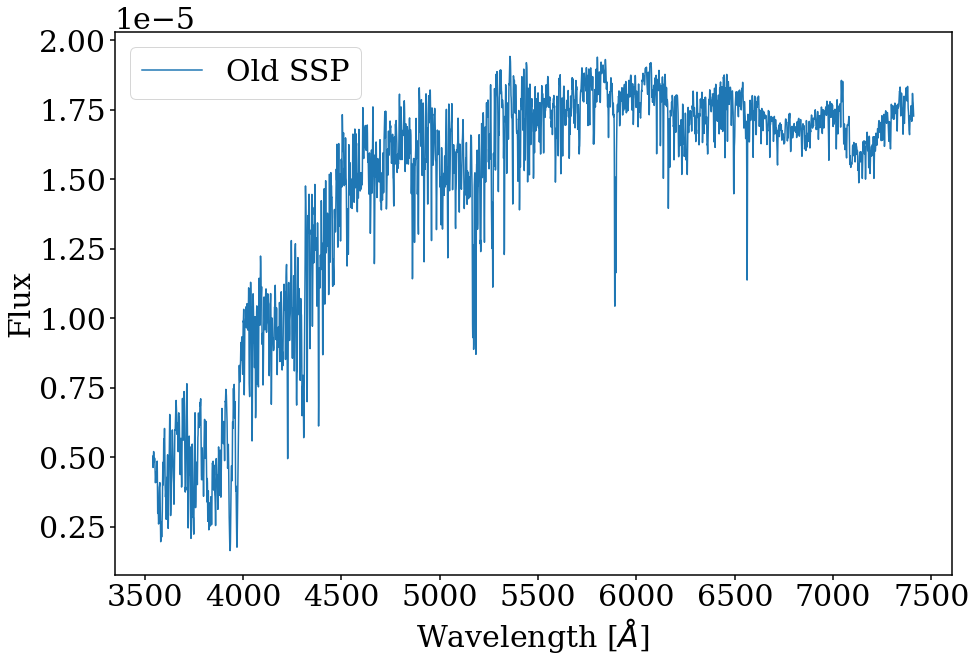

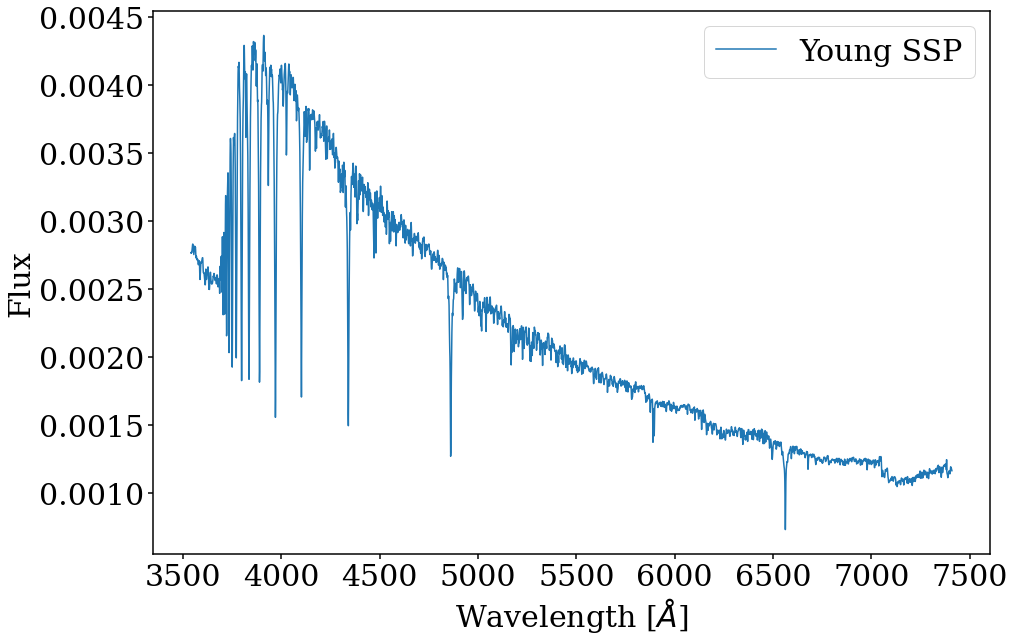

In [15]:
plt.plot(wave,spec_o,label='Old SSP')
plt.ylabel('Flux')
plt.xlabel('Wavelength [$\\AA$]')
plt.legend()
plt.show()

plt.plot(wave,spec_y,label='Young SSP')
plt.ylabel('Flux')
plt.xlabel('Wavelength [$\\AA$]')
plt.legend()
plt.show()



We try to simulate in MILES spectra a velocity dispersion of $300$ km/s

$$\sigma_{diff}= \sigma_{300}**2 + \sigma_{ins}**2 - \sigma_{MILES}**2$$

where $FWMH_{MILES} = 2.51 A$ and as $R=\frac{\lambda}{\Delta \lambda} = \frac{c}{\sigma}$, then
$\sigma_{MILES}=\frac{\Delta \lambda \cdot c}{\lambda}$.


$\sigma_{ins}$ is instroduced by the SDSS instrument and we get it from SPIDER VIII paper (La Barbera 13)


In [17]:
#convolution

cvel=300000 #km/s

psize=0.9 #miles delta lambda
fluxes_conv_miles=[]
sigma_miles=cvel * psize / wave #km/s

fwhm_sdss=np.ones((len(wave)))

def fwhm(l): #units: amstrong
    if l>3999 and l<5500:
        fwmh=0.01*l-37.85
    elif l>=5500 and l<6001:
        fwmh=
        


sigma_sdss=fwhm_sdss/(2.*np.sqrt(2.*np.log(2.)))


max_sigma=np.sqrt(300**2+sigma_sdss**2-sigma_miles**2)


FWHM_gal = 2.*np.sqrt(2.*np.log(2.)) * max_sigma / cvel * wave
FWHM_dif = np.sqrt(FWHM_gal**2)
sigma = FWHM_dif/(psize*2.*np.sqrt(2.*np.log(2.))) # Sigma difference in pixels
spec_o_conv = gaussian_filter1d(spec_o, sigma)
spec_y_conv = gaussian_filter1d(spec_y, sigma)

NameError: name 'sigma_sdss' is not defined

[179.21197571 179.16643135 179.12091014 ...  85.65296039  85.64255537
  85.63215288] ... it should be 2.51 A, the FWMH of MILES 
[76.2604152  76.24103462 76.22166389 ... 36.44806825 36.44364058
 36.43921399]


Text(0.5, 0, 'Wavelength [$\\AA$]')

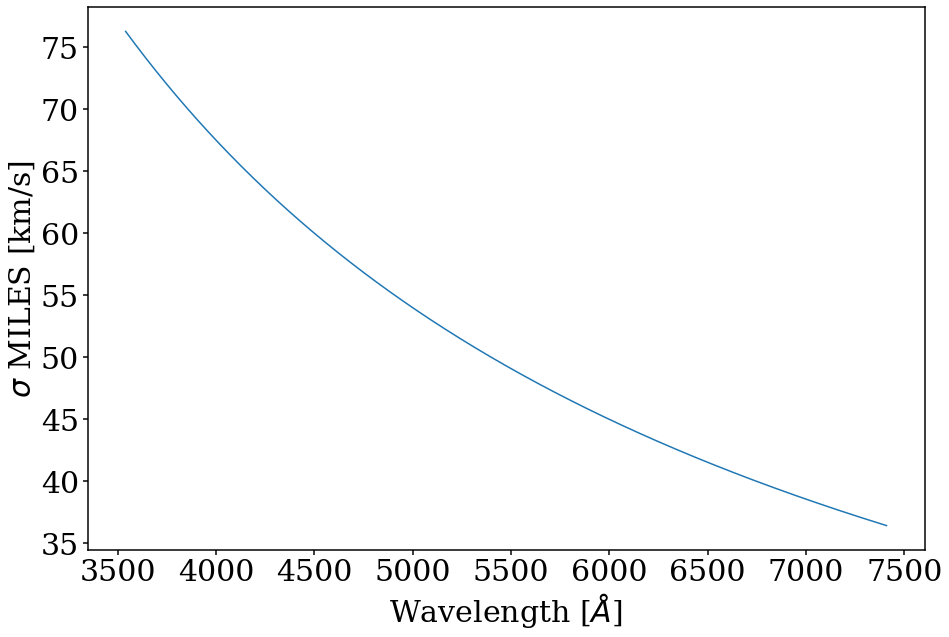

In [18]:
#print(sigma_miles*2.35, '... it should be 2.51 A, the FWMH of MILES ') ???

print(sigma_miles)
plt.plot(wave,sigma_miles)
plt.ylabel('$\\sigma$ MILES [km/s]')
plt.xlabel('Wavelength [$\\AA$]')

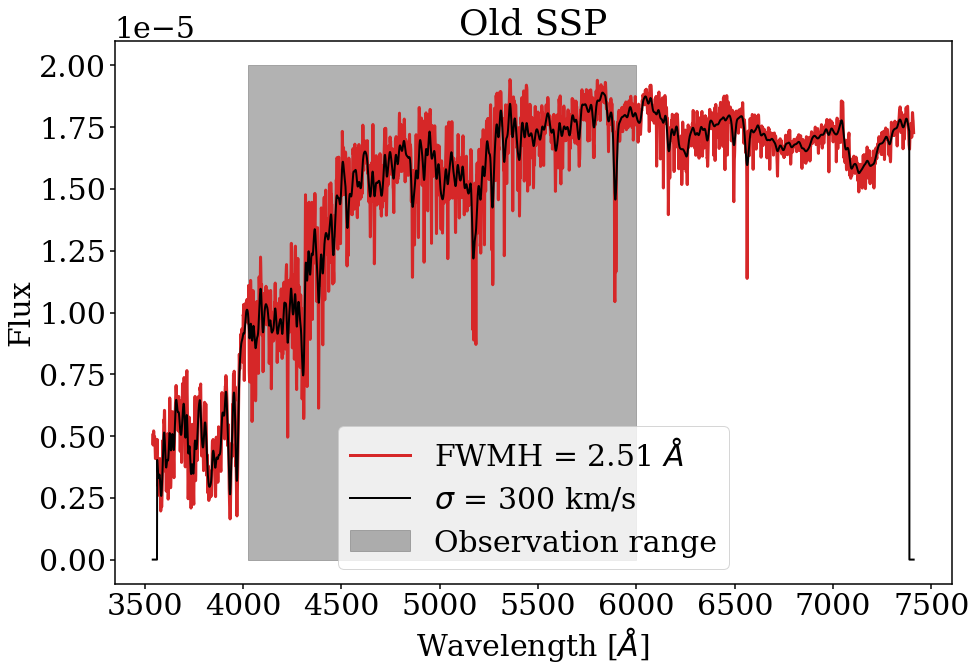

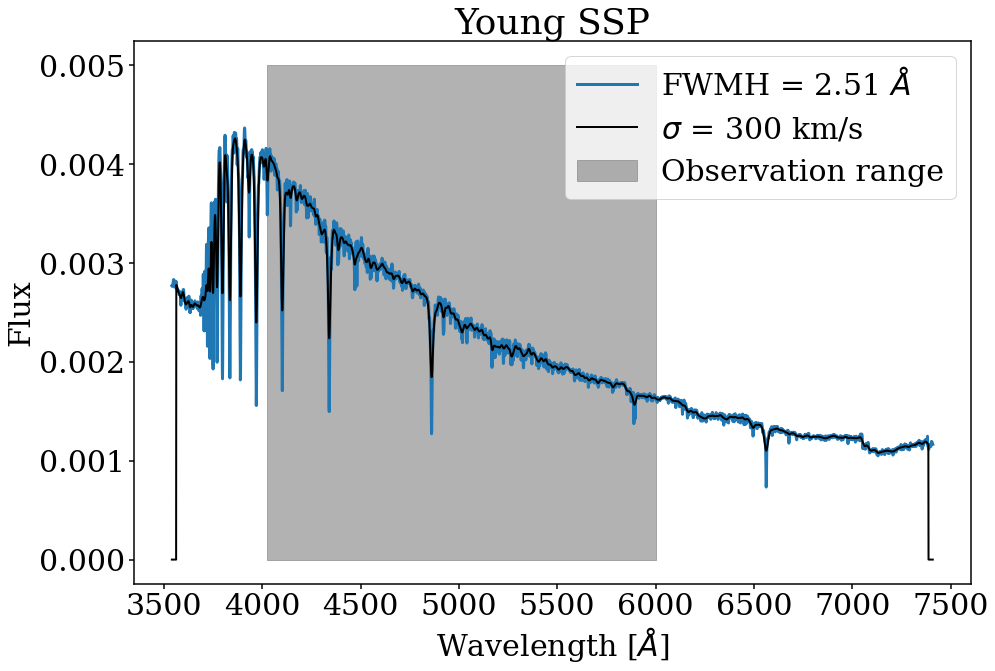

In [19]:
plt.plot(wave,spec_o,label='FWMH = 2.51 $\AA$',lw=3,c='tab:red')
plt.plot(wave,spec_o_conv,label='$\\sigma$ = '+str(max_sigma)+' km/s',lw=2,c='k')
plt.ylabel('Flux')
plt.xlabel('Wavelength [$\\AA$]')
plt.title('Old SSP')
plt.fill_betweenx([0,2e-5],4023,6000,label='Observation range',alpha=0.6,color='grey')
plt.legend()
plt.show()

plt.plot(wave,spec_y,label='FWMH = 2.51 $\AA$',lw=3,c='tab:blue')
plt.plot(wave,spec_y_conv,label='$\\sigma$ = '+str(max_sigma)+' km/s',lw=2,c='k')
plt.ylabel('Flux')
plt.xlabel('Wavelength [$\\AA$]')
plt.title('Young SSP')
plt.fill_betweenx([0,0.005],4023,6000,label='Observation range',alpha=0.6,color='grey')
plt.legend()
plt.show()


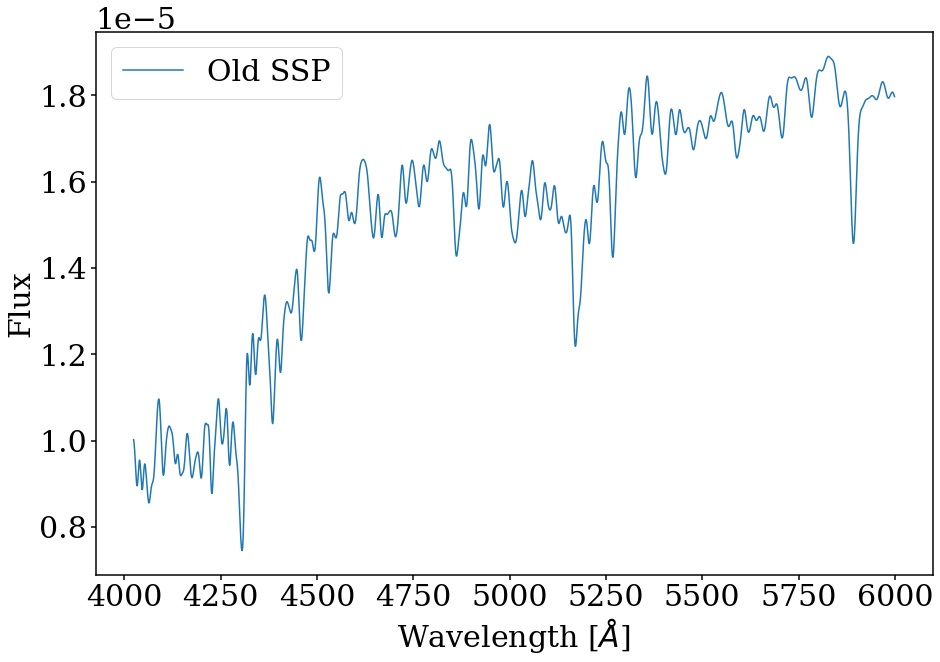

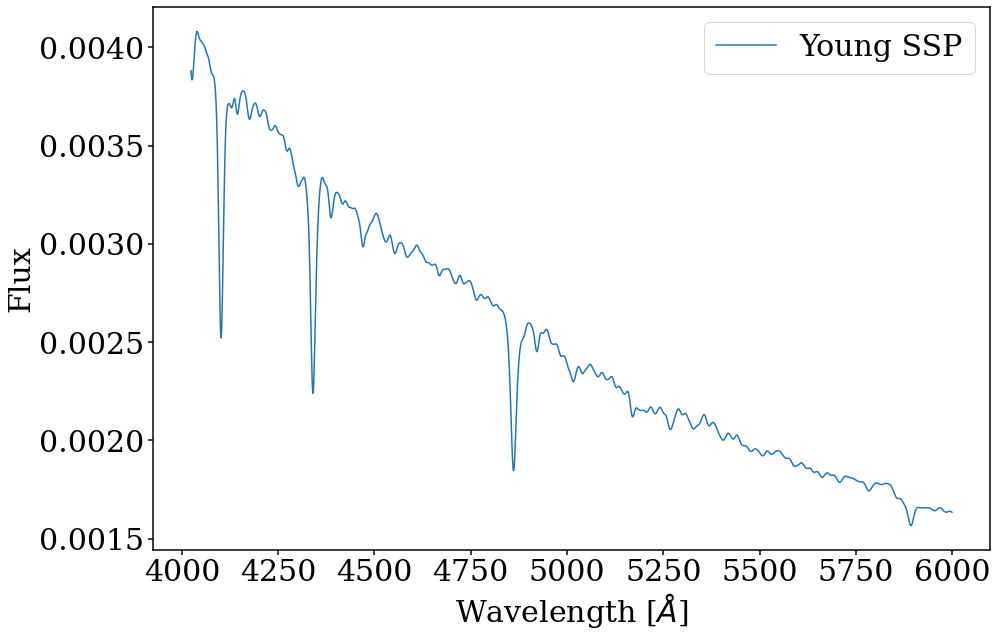

In [17]:
#short range (with spectra already convolved)

ind=np.where((wave>4022.9)&(wave<6000.1))[0]
wave_short=wave[ind]
spec_o_short=spec_o_conv[ind]
spec_y_short=spec_y_conv[ind]

plt.plot(wave_short,spec_o_short,label='Old SSP')
plt.ylabel('Flux')
plt.xlabel('Wavelength [$\\AA$]')
plt.legend()
plt.show()

plt.plot(wave_short,spec_y_short,label='Young SSP')
plt.ylabel('Flux')
plt.xlabel('Wavelength [$\\AA$]')
plt.legend()
plt.show()
